In [1]:
from metavision_core.event_io import RawReader
import warnings

files = [ f.strip() for f in input("Enter the path to the files: ").split(',') ]
records = [ RawReader(f) for f in files ]
height, width = records[0].get_size()
print('record dimensions: ', height, width)
#start_ts = 100
#records[0].seek_time(20e6) # seek to 1 second
delta_t = 1e6 #sampling duration
events = []

for record in records:
    try:
        #record.seek_time(7e6)
        local_events = record.load_delta_t(delta_t)
        local_events['t'] -= local_events[0]['t'] # important! almost all preprocessing use relative time!
        events.append(local_events)
    except:
        warnings.warn("Unable to seek to 7s in record")
        # reset the record and don't seek
        record.reset()
        local_events = record.load_delta_t(delta_t)
        local_events['t'] -= local_events[0]['t'] # important! almost all preprocessing use relative time!
        events.append(local_events)
        
        


record dimensions:  480 640


In [5]:
len(events)

1

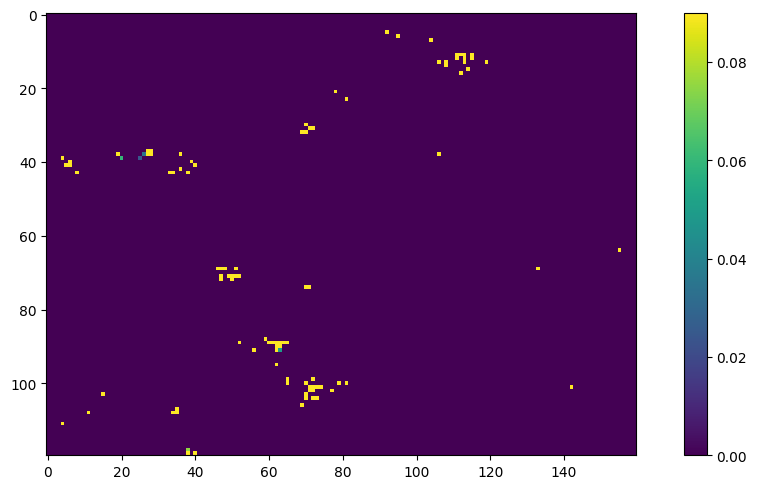

: 

In [18]:
from metavision_ml.preprocessing import timesurface
from metavision_ml.preprocessing.viz import filter_outliers
import numpy as np
import matplotlib.pyplot as plt

# plot 2 time surfaces side by side (one for each recording)

tbins = 5000
volume_1 = np.zeros((tbins, 2, height//4, width//4))
#volume_2 = np.zeros((tbins, 2, height, width))

timesurface(events[0], volume_1, delta_t, downsampling_factor=2, normed=True)
#timesurface(events[1], volume_2, delta_t, normed=True)

sum1 = np.sum(volume_1[:, 1], axis=0)
sum1 = sum1 / np.max(sum1)
#sum2 = np.sum(volume_2[:, 1], axis=0)
#sum2 = sum2 / np.max(sum2)

plt.figure(figsize=(10, 5))
#ax1 = plt.subplot(121)
#im1 = plt.imshow(sum1, aspect='auto')
#ax2 = plt.subplot(122)
#im2 = plt.imshow(sum2, aspect='auto')
im1 = plt.imshow(filter_outliers(volume_1[1, 1], 2))
# Create an axis for the colorbar on the right of the current axis
#cbar_ax = plt.gcf().add_axes([1, 0.15, 0.03, 0.7])

# Add a colorbar to the cbar_ax
plt.colorbar(im1)

# Add a title for the whole plot
#plt.suptitle('Time surface diffuser no motor\n90:10 splitter and corrected magnification')

# Add a title for each subplot
#ax1.set_title('Stationary')
#ax2.set_title('Moving')
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_4500\2832568999.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  circularities = [4 * np.pi * prop.area / (prop.perimeter ** 2) for prop in props]
C:\Users\User\AppData\Local\Temp\ipykernel_4500\2832568999.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


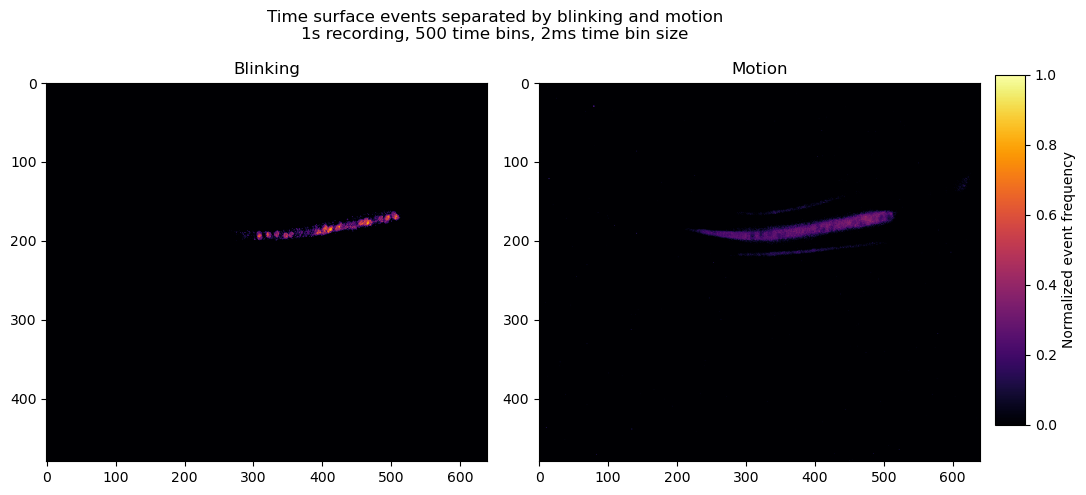

In [54]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from metavision_ml.preprocessing import timesurface
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops

if len(events) != 1:
    # warning: this example is designed for 1 recording, make sure the first
    # recording is the one you want to use
    warnings.warn(
        'This example is designed for 1 recording. \
            Make sure the first recording is the one you want to use')



def identify_blinking(volume):
    '''
    Identify blinking and moving events in a volume of events by looking for 'on' events that
    have 'off' events within a 10px radius and whose time difference is greater than 100us.
    Only keep event clusters that approximate a circle for blinking events.
    All other events are classified as moving.
    '''
    # Extract 'on' events (polarity = 1) and 'off' events (polarity = 0)
    on_events = volume[:, 1, :, :]
    off_events = volume[:, 0, :, :]

    # Initialize an array to hold blinking events
    blinking = np.zeros_like(on_events)

    # Define the radius
    radius = 4

    for t in range(tbins):
        # Get the coordinates of 'on' and 'off' events
        on_coords = np.argwhere(on_events[t] > 10)
        off_coords = np.argwhere(off_events[t] > 10)

        if len(on_coords) > 0 and len(off_coords) > 0:
            # Calculate the Euclidean distance between 'on' and 'off' events
            dists = cdist(on_coords, off_coords)

            # Check if there's an 'off' event within a 10px radius of each 'on' event
            within_radius = np.any(dists <= radius, axis=1)

            # Get the y and x coordinates of the selected 'on' events
            selected_y = on_coords[within_radius, 0]
            selected_x = on_coords[within_radius, 1]

            # Get the time stamps of the selected 'on' events and the 'off' events
            on_ts = on_events[t, selected_y, selected_x]
            off_ts = off_events[t, selected_y, selected_x]

            # Keep only events that are at least 100us apart
            selected_y = selected_y[np.abs(on_ts - off_ts) > 100]
            selected_x = selected_x[np.abs(on_ts - off_ts) > 100]

            # Mark selected 'on' events as 'blinking'
            blinking[t, selected_y, selected_x] = on_events[t, selected_y, selected_x]

            # Label connected components in the 'blinking' array
            labels = label(blinking[t], connectivity=1)

            # Calculate the circularity of each connected component
            props = regionprops(labels)
            circularities = [4 * np.pi * prop.area / (prop.perimeter ** 2) for prop in props]

            # Keep only components that approximate a circle
            for i, circularity in enumerate(circularities):
                if circularity < 0.95:  # adjust this threshold as needed
                    blinking[t, labels == i + 1] = 0

    # Classify the remaining 'on' events as 'moving'
    moving = on_events - blinking

    return blinking, moving

tbins = 500
volume = np.zeros((tbins, 2, height, width))
timesurface(events[0], volume, delta_t, normed=False) 
blinking, motion = identify_blinking(volume)

# Summing over the time axis to get a 2D image
blinking_sum = np.sum(blinking, axis=0)
blinking_sum = blinking_sum / np.max(blinking_sum) if np.max(blinking_sum) > 0 else blinking_sum   # normalize
motion_sum = np.sum(motion, axis=0)
motion_sum = motion_sum / np.max(motion_sum) if np.max(motion_sum) > 0 else motion_sum # normalize

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
im1 = plt.imshow(blinking_sum, cmap='inferno', aspect='auto')
ax2 = plt.subplot(122)
im2 = plt.imshow(motion_sum, cmap='inferno', aspect='auto')

# Create an axis for the colorbar on the right of the current axis
cbar_ax = plt.gcf().add_axes([1, 0.15, 0.03, 0.7])

# Add a colorbar to the cbar_ax
plt.colorbar(im2, cax=cbar_ax)

# Add a title for the whole plot
plt.suptitle(
    'Time surface events separated by blinking and motion\n1s recording, 500 time bins, 2ms time bin size')

# Add a title for each subplot
ax1.set_title('Blinking')
ax2.set_title('Motion')

# add a label to the colorbar
cbar_ax.set_ylabel('Normalized event frequency')

plt.tight_layout()
plt.show()



In [ ]:
def identify_blinking(volume):
    '''
    Identify blinking events in a volume of events by looking for 'on' events that
    have 'off' events within a 10px radius and whose time difference is greater than 100us.
    '''
    # Extract 'on' events (polarity = 1) and 'off' events (polarity = 0)
    on_events = volume[:, 1, :, :]
    off_events = volume[:, 0, :, :]

    # Initialize an array to hold blinking events
    blinking = np.zeros_like(on_events)

    # Define the radius
    radius = 10

    for t in range(tbins):
        # Get the coordinates of 'on' and 'off' events
        on_coords = np.argwhere(on_events[t] > 10)
        off_coords = np.argwhere(off_events[t] > 10)

        if len(on_coords) > 0 and len(off_coords) > 0:
            # Calculate the Euclidean distance between 'on' and 'off' events
            dists = cdist(on_coords, off_coords)

            # Check if there's an 'off' event within a 10px radius of each 'on' event
            within_radius = np.any(dists <= radius, axis=1)

            # Get the y and x coordinates of the selected 'on' events
            selected_y = on_coords[within_radius, 0]
            selected_x = on_coords[within_radius, 1]

            # Get the time stamps of the selected 'on' events and the 'off' events
            on_ts = on_events[t, selected_y, selected_x]
            off_ts = off_events[t, selected_y, selected_x]

            # Keep only events that are at least 100us apart
            selected_y = selected_y[np.abs(on_ts - off_ts) > 100]
            selected_x = selected_x[np.abs(on_ts - off_ts) > 100]

            # Mark selected 'on' events as 'blinking'
            blinking[t, selected_y, selected_x] = on_events[t, selected_y, selected_x]

    return blinking

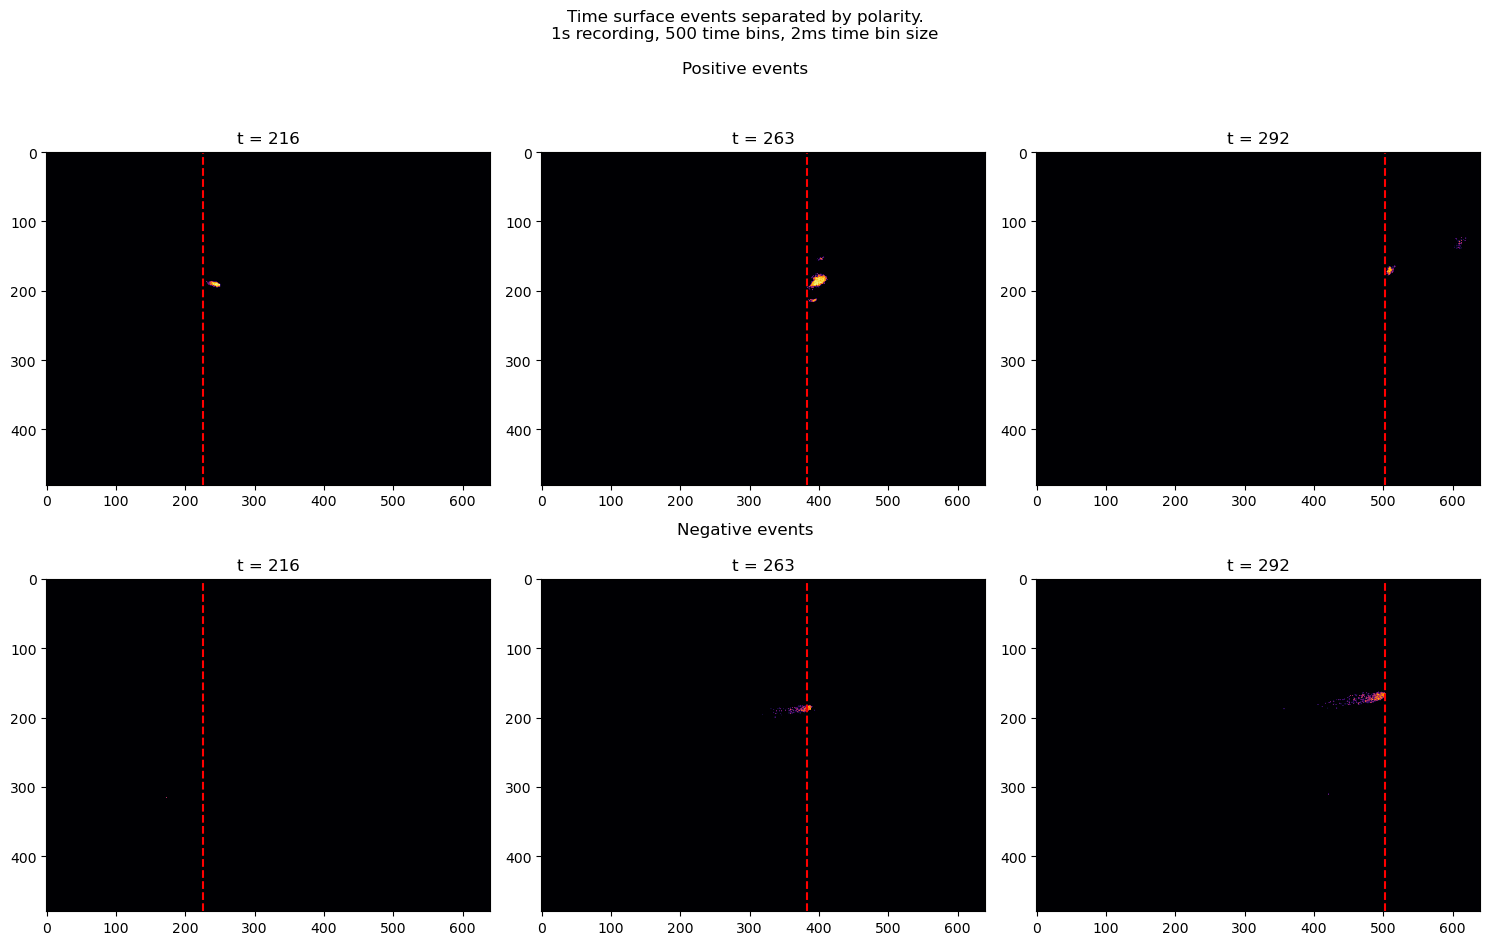

In [94]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from metavision_ml.preprocessing import timesurface

if len(events) != 1:
    # warning: this example is designed for 1 recording, make sure the first
    # recording is the one you want to use
    warnings.warn(
        'This example is designed for 1 recording. \
            Make sure the first recording is the one you want to use')


tbins = 500
volume = np.zeros((tbins, 2, height, width))
timesurface(events[0], volume, delta_t, normed=True)


# plot the positive and negative events separately for 3 time bins equally spaced in time
plt.figure(figsize=(15, 10))

nonzero_bins = np.nonzero(volume[:, 1])
t_bins = nonzero_bins[0]
# filter t_bins to include only bins with more than 100 events
t_bins = np.array([t for t in t_bins if len(nonzero_bins[1][nonzero_bins[0] == t]) > 100])

spacing = np.linspace(0, len(t_bins) - 1, 3).astype(int)

for i, s in enumerate(spacing):
    t = t_bins[s]
    plt.subplot(2, 3, i + 1)
    plt.imshow(volume[t, 1], cmap='inferno')
    plt.title('t = {}'.format(t))
    plt.subplot(2, 3, i + 4)
    plt.imshow(volume[t, 0], cmap='inferno')
    plt.title('t = {}'.format(t))
    
    # plot a red dotted line at the x location where events begin and end
    plt.subplot(2, 3, i + 1)
    plt.axvline(x=np.min(nonzero_bins[2][nonzero_bins[0] == t]), color='r', linestyle='--')
    plt.subplot(2, 3, i + 4)
    plt.axvline(x=np.min(nonzero_bins[2][nonzero_bins[0] == t]), color='r', linestyle='--')


plt.tight_layout()
# Add titles for each row

plt.subplots_adjust(top=.9)
plt.figtext(0.5, 0.92, 'Positive events', ha='center', va='center', fontsize=12)
plt.figtext(0.5, 0.46, 'Negative events', ha='center', va='center', fontsize=12)

plt.suptitle('Time surface events separated by polarity.\n1s recording, 500 time bins, 2ms time bin size')

plt.show()

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from metavision_ml.preprocessing import timesurface
from metavision_sdk_cv import SparseOpticalFlowAlgorithm, SparseOpticalFlowConfigPreset

if len(events) != 1:
    # warning: this example is designed for 1 recording, make sure the first
    # recording is the one you want to use
    warnings.warn(
        'This example is designed for 1 recording. \
            Make sure the first recording is the one you want to use')

step = 5
tbins = 500
volume = np.zeros((tbins, 2, height, width))
timesurface(events[0], volume, delta_t, normed=False)
volume_slice = volume[:, 1, :, :] # use only positive events

flow_algo = SparseOpticalFlowAlgorithm(
    width, height, SparseOpticalFlowConfigPreset.FastObjects)
flow_buffer = SparseOpticalFlowAlgorithm.get_empty_output_buffer()

flow_algo.process_events(events[0], flow_buffer)
print(flow_buffer.numpy())

[(231, 189, 1, 429042,   2.586455 ,   0.30960065, 259, 219.36888, 187.04419)
 (231, 188, 1, 429042,   2.586455 ,   0.30960065, 259, 219.36888, 187.04419)
 (234, 191, 1, 429102,   2.6742418,   0.33333552, 259, 219.38145, 187.04756)
 ...
 (503, 167, 0, 631548, 987.27625  , -81.77986   , 282, 475.2128 , 175.92537)
 (508, 171, 0, 631793, 988.0795   , -81.900536  , 282, 475.56827, 175.88828)
 (498, 165, 0, 635816, 997.1038   , -86.28089   , 282, 480.81934, 174.9394 )]
